The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 序列模型
:label:`sec_sequence`

想象一下你正在看 Netflix（一个国外的视频网站）上的电影。作为一个很棒的 Netflix 用户，你决定对每一部电影都给出评价。毕竟，一部好的电影值得好电影的称呼，而且你想看更多的好电影，对吧？事实证明，事情并不那么简单。随着时间的推移，人们对电影的看法会发生很大的变化。事实上，心理学家甚至对某些效应起了名字：

* *锚定*（anchoring），基于其他人的意见。例如，奥斯卡颁奖后，受到关注的电影的评分会上升，尽管它还是原来那部电影。这种影响将持续几个月，直到人们忘记了这部电影曾经获得的奖项。结果表明，这种效应会使评分提高半个百分点以上
  :cite:`Wu.Ahmed.Beutel.ea.2017`.
* *享乐适应*（hedonic adaption），即人类迅速接受并且适应一种更好或者更坏的情况作为新的常态。例如，在看了很多好电影之后，人们期望下一部电影会同样好或者更好。因此，在看过许多精彩的电影之后，即使是一部普通的电影也可能被认为是糟糕的。
* *季节性*（seasonality）。少有观众喜欢在八月看圣诞老人的电影。
* 有时候，电影会由于导演或演员在制作中的不当行为变得不受欢迎。
* 有些电影因为其极度糟糕只能成为小众电影。*Plan 9 from Outer Space* 和 *Troll 2* 就因为这个原因而臭名昭著的。

简而言之，电影评分决不是固定不变的。因此，使用时间动力学可以得到更准确的电影推荐 :cite:`Koren.2009` 。当然，序列数据不仅仅是关于电影评分的。下面给出了更多的场景。

* 在使用应用程序时许多用户都有很强的特定习惯。例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
* 预测明天的股价要比填补昨天遗失的股价的更困难，尽管两者都只是估计一个数字。毕竟，先见之明比事后诸葛亮难得多。在统计学中，前者（超出已知观测值的预测）称为 *外推*（extrapolation），而后者（在现有观测值之间进行估计）称为 *内插*（interpolation）。
* 在本质上音乐、语音、文本和视频都是连续的。如果我们对它们进行序列重排，它们就会失去意义。文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
* 地震具有很强的相关性，即大地震发生后，很可能会有几次较小的余震，这些余震比没有强震的余震要大得多。事实上，地震是时空相关的，也就是说，余震通常发生在很短的时间跨度和很近的距离内。
* 人类之间的互动也是连续的，这可以从推特上的争吵和辩论中看出。

## 统计工具

我们需要统计工具和新的深层神经网络结构来处理序列数据。为了简单起见，我们以 :numref:`fig_ftse100` 所示的股票价格（富时100指数）为例。

![近30年的富时100指数。](../img/ftse100.png)
:width:`400px`
:label:`fig_ftse100`

让我们用 $x_t$ 表示价格。即在 *时间步*（time step）$t \in \mathbb{Z}^+$时，我们观察到的价格 $x_t$。请注意，对于本文中的序列，$t$ 通常是离散的，并随整数或其子集而变化。假设一个交易员想在 $t$ 日股市表现良好的，于是通过以下途径预测了 $x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### 自回归模型

为了实现这一点，交易员可以使用回归模型，比如我们在 :numref:`sec_linear_concise` 中训练的模型。只有一个主要问题：输入 $x_{t-1}, \ldots, x_1$ 的数量因 $t$ 而异。也就是说，这个数字将会随着我们遇到的数据量的增加而增加，因此我们需要一个近似方法来使这个计算变得容易处理。本章后面的大部分内容将围绕着如何有效估计 $P(x_t \mid x_{t-1}, \ldots, x_1)$ 展开。简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列 $x_{t-1}, \ldots, x_1$ 可能是不需要的，因此我们只使用观测序列 $x_{t-1}, \ldots, x_{t-\tau}$，并且满足于时间跨度为 $\tau$。现在，获得的最直接的好处就是对于 $t > \tau$ 时参数的数量总是相同的，这就使我们能够训练一个上面提及的深层网络。这种模型被称为 *自回归模型*（autoregressive models），因为它们就是对自己执行回归。

第二种策略，如 :numref:`fig_sequence-model` 所示，是保留一些过去观测的总计 $h_t$，同时除了预测 $\hat{x}_t$ 之外还更新 $h_t$。这就产生了估计 $x_t$ 和 $\hat{x}_t = P(x_t \mid h_{t})$ 的模型，并且更新了 $h_t = g(h_{t-1}, x_{t-1})$。由于 $h_t$ 从未被观测到，这类模型也被称为 *隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](../img/sequence-model.svg)
:label:`fig_sequence-model`

这两种情况都有一个显而易见的问题，即如何生成训练数据。一个经典的方法是使用历史观测来预测下一次的观测。显然，我们并不指望时间会停滞不前。然而，一个常见的假设是序列本身的动力学不会改变，虽然特定值 $x_t$ 可能会改变。这样的假设是合理的，因为新的动力学一定受新数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为 *静止的*（stationary）。因此，无论我们做什么，整个序列的估计值都将通过以下的方式获得

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理离散的对象(如单词)，而不是连续的数字，则上述的考虑仍然有效。唯一的差别是，在这种情况下，我们需要使用分类器而不是回归模型来估计 $P(x_t \mid  x_{t-1}, \ldots, x_1)$。

### 马尔可夫模型

回想一下，在自回归模型的逼近方法中，我们使用 $x_{t-1}, \ldots, x_{t-\tau}$ 而不是 $x_{t-1}, \ldots, x_1$ 来估计 $x_t$。只要这种近似是准确的，我们就说序列满足*马尔可夫条件*（Markov condition）。特别是，如果 $\tau = 1$，得到一个*一阶马尔可夫模型*（first-order Markov model），$P(x)$ 由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1).$$

当 $x_t$ 只假设离散值时，这样的模型特别棒，因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察到的非常短的历史：$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。详细介绍动态规划超出了本节的范围。控制算法和强化学习算法广泛使用这些工具。

### 因果关系

原则上，倒序展开 $P(x_1, \ldots, x_T)$ 无可厚非。毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，我们可以得到一个反向的条件概率分布。然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。很明显，未来的事件不能影响过去。因此，如果我们改变 $x_t$，我们可能能够影响 $x_{t+1}$ 未来发生的事情，但不能影响过去。也就是说，如果我们改变 $x_t$，基于过去事件的分布不会改变。因此，解释 $P(x_{t+1} \mid x_t)$ 应该比解释 $P(x_t \mid x_{t+1})$ 更容易。例如，在某些情况下，对于某些可加性噪声 $\epsilon$，显然我们可以找到 $x_{t+1} = f(x_t) + \epsilon$，而反之则不行 :cite:`Hoyer.Janzing.Mooij.ea.2009` 。这是个好消息，因为这通常是我们有兴趣估计的前进方向。彼得斯等人写的这本书。已经解释了关于这个主题的更多内容 :cite:`Peters.Janzing.Scholkopf.2017` 。我们仅仅触及了它的皮毛。

## 训练

在回顾了这么多统计工具之后，让我们在实践中尝试一下。首先，生成一些数据。为了简单起见，我们使用正弦函数和一些可加性噪声来生成序列数据，时间步为$1, 2, \ldots, 1000$。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


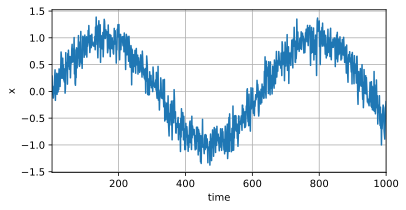

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们需要将这样的序列转换为我们的模型可以训练的特征和标签。基于嵌入维度 $\tau$，我们将数据映射为 $y_t = x_t$ 和 $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。精明的读者可能已经注意到，这比我们提供的数据样本少了 $\tau$ 个，因为我们没有足够的历史记录来描述前 $\tau$ 个数据样本。一个简单的解决办法，特别是序列如果够长就丢弃这几项，或者可以用零填充序列。在这里，我们仅使用前600个“特征－标签”对进行训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

这里的结构相当简单：只是一个多层感知机，有两个全连接层、ReLU激活函数和平方损失。


In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss()

现在我们准备好等待训练的模型了。下面的代码与前面几节中的训练代码实现方式基本相同，如 :numref:`sec_linear_concise` 。因此，我们不会深入探讨太多细节。


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.048389
epoch 2, loss: 0.045942
epoch 3, loss: 0.046593
epoch 4, loss: 0.047084


epoch 5, loss: 0.048391


## 预测

由于训练损失很小，我们希望模型能够很好地工作。让我们看看这在实践中意味着什么。首先是检查模型对发生在下一个时间步的事情的预测能力有多好，也就是 *单步预测*（one-step-ahead prediction）。


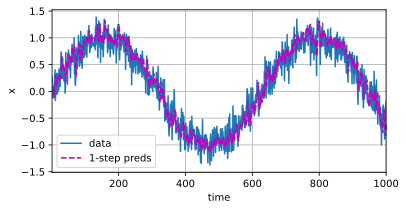

In [7]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

正如我们所料的单步预测效果不错。即使这些预测的时间步超过了 $604$（`n_train + tau`），其结果看起来仍然是可信的。然而有一个小问题：如果数据观察序列的时间步只到 $604$，那么我们没有期望能够接收到所有提前一步预测的未来输入。相反，我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到 $x_t$ 的观测序列，其在时间步长 $\hat{x}_{t+k}$ 处的预测输出 $t+k$ 被称为 *$k$ 步预测*（$k$-step-ahead-prediction）。由于我们已经观察到了 $x_{604}$，它领先 $k$ 步的预测是 $\hat{x}_{604+k}$。换句话说，我们将不得不使用自己的预测来进行多步预测。让我们看看这件事进行的是否顺利。


In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

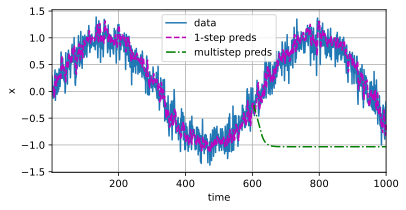

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

正如上面的例子所示，这是一个巨大的失败。在几个预测步骤之后，预测结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？最终事实是由于错误的累积。假设在步骤 $1$ 之后，我们积累一些错误 $\epsilon_1 = \bar\epsilon$。现在，步骤 $2$ 的 *输入*（input）被扰动了 $\epsilon_1$，因此积累的误差是依照次序的 $\epsilon_2 = \bar\epsilon + c \epsilon_1$，其中 $c$ 为某个常数，后面的预测误差依此类推。所以一个普遍的现象是误差可能会相当快地偏离真实的观测结果。例如，未来24小时的天气预报往往相当准确，但超过这一点，准确率就会迅速下降。我们将在本章及以后讨论改进这一点的方法。

让我们通过计算 $k = 1, 4, 16, 64$ 的整个序列的预测来更仔细地看一下 $k$ 步预测的困难。


In [10]:
max_steps = 64

In [11]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

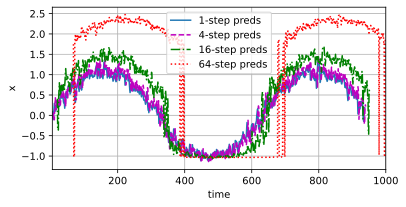

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

这清楚地说明了当我们试图进一步预测未来时，预测的质量是如何变化的。虽然“$4$ 步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。

## 小结

* 内插和外推在难度上差别很大。因此，在训练时始终要尊重你所拥有的序列数据的时间顺序，即永远不要训练未来的数据。
* 序列模型的估计需要专门的统计工具。两种流行的选择是：自回归模型和隐变量自回归模型。
* 对于因果模型（例如，时间是向前推进的），正向估计通常比反向估计更容易。
* 对于直到时间步 $t$ 的观测序列，其在时间步 $t+k$ 的预测输出是"$k$步预测"。随着我们在预测时间上进一步增加 $k$，会造成误差累积，导致预测质量下降。

## 练习

1. 改进本节实验中的模型。
    1. 是否包含了过去4个以上的观测结果？你的真实需要是多少？
    1. 如果没有噪音，你需要多少个过去的观测结果？提示：你可以把$\sin$和$\cos$写成微分方程。
    1. 你能在保持特征总数不变的情况下合并旧的观察结果吗？这能提高精确度吗？为什么？
    1. 改变神经网络结构并评估其性能。
1. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？
1. 因果关系也适用于文本吗？在多大程度上？
1. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。


[Discussions](https://discuss.d2l.ai/t/2091)
